### Download dataset

In [ ]:

# !pip install -U -q kaggle
# !pip install  --quiet --upgrade tensorflow-federated-nightly nest-asyncio
# !mkdir -p ~/.kaggle
# !echo '{"username":"zhihaoliang","key":"37c44f583a070043285e729aa9e9ab09"}' > ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json
 
# !kaggle datasets download -d paultimothymooney/breast-histopathology-images
# !mkdir data
# !unzip -q breast-histopathology-images.zip -d ./data

### Import libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
import glob
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split


### Print data size and last 10 images in the set

In [ ]:
from glob import glob
image_pixel=50
images_num=15000
data = glob('./data/**/**/*.png', recursive=True)
print(len(data))
data[-10:]


1942668


['./data/9265/0/9265_idx5_x601_y1301_class0.png',
 './data/9265/0/9265_idx5_x2701_y1051_class0.png',
 './data/9265/0/9265_idx5_x1601_y201_class0.png',
 './data/9265/0/9265_idx5_x2251_y1401_class0.png',
 './data/9265/0/9265_idx5_x1351_y1301_class0.png',
 './data/9265/0/9265_idx5_x3651_y1201_class0.png',
 './data/9265/0/9265_idx5_x1901_y1251_class0.png',
 './data/9265/0/9265_idx5_x51_y801_class0.png',
 './data/9265/0/9265_idx5_x2351_y1501_class0.png',
 './data/9265/0/9265_idx5_x751_y1201_class0.png']

### Show ten sample images

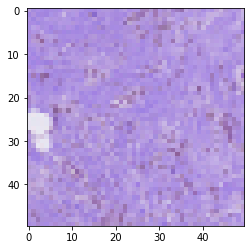

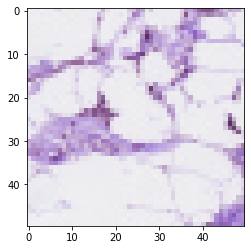

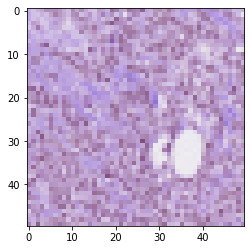

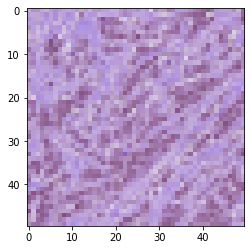

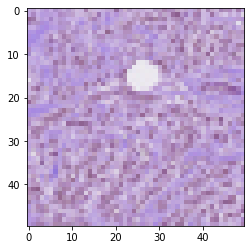

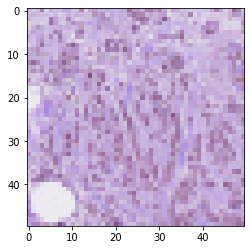

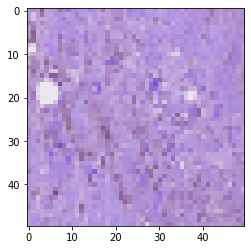

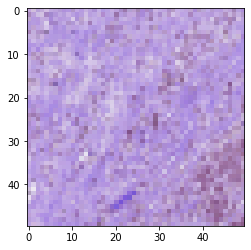

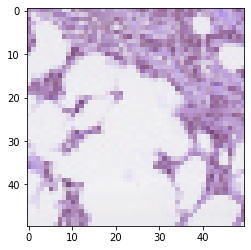

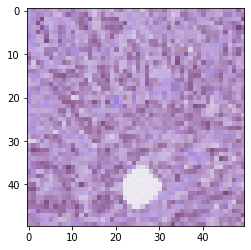

In [ ]:
import cv2
import matplotlib.pyplot as plt
for i in data[:10]:
    img=cv2.imread(i)
    img_1=cv2.resize(img,(image_pixel,image_pixel))
    plt.imshow(img_1,cmap='binary')
    plt.show()

### Define build tfrecord data method

In [ ]:
def encoder(filenames, labels, tfrecord_file):
    with tf.io.TFRecordWriter(tfrecord_file) as writer:
        for filename, label in zip(filenames, labels):
            image = open(filename, 'rb').read()

            feature = {
                # build feature dict       
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
            }

            # create example through dict
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())


### select images and balance label percentage between IDC (+) and IDC (-)

In [ ]:
from collections import Counter
labels=[]
x_filenames=[]
one_size=0.5
one_num=int(images_num*one_size) 
zero_num=int(images_num*(1-one_size)) 

one_count=0
zero_count=0
for i in data:
    if i.endswith('.png'):
        label=int(i[-5])
        if images_num == len(labels):
            break
        if label==1 and one_count==one_num:
            continue
        if label==0 and zero_count==zero_num:
            continue
        if label == 1:
            one_count+=1
        if label == 0:
            zero_count+=1
        x_filenames.append(i)
        labels.append(label)

!mkdir tfrecord
train_tfrecord_file='./tfrecord/train.tfrecords'
test_tfrecord_file='./tfrecord/test.tfrecords'

train_images_filename,test_images_filename,train_labels_filename,test_labels_filename= \
train_test_split(x_filenames,labels,random_state=0,test_size=0.3)
print(Counter(labels))

mkdir: cannot create directory ‘tfrecord’: File exists
Counter({1: 7500, 0: 7500})


### Build train dataset and test dataset from tfrecord data

In [ ]:
def decoder(tfrecord_file):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    feature_discription = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    def _parse_example(example_string): # decode each example
        feature_dic = tf.io.parse_single_example(example_string, feature_discription)
        feature_dic['image'] = tf.io.decode_png(feature_dic['image'])
        feature_dic['image'] = tf.image.resize(feature_dic['image'], [image_pixel, image_pixel])/255
        return feature_dic['image'], feature_dic['label']


    # if is_train_dataset is not None:
    dataset = dataset.map(_parse_example)


    return dataset

encoder(train_images_filename,train_labels_filename,train_tfrecord_file)
encoder(test_images_filename,test_labels_filename,test_tfrecord_file)
train_data= decoder(train_tfrecord_file)
test_data = decoder(test_tfrecord_file)


train_images, train_labels = tuple(zip(*train_data))
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images,test_labels= tuple(zip(*test_data))
test_images = np.array(test_images)
test_labels = np.array(test_labels)

### import libraries

In [ ]:
from tensorflow.keras import datasets, layers, models
import tensorflow_federated as tff
import collections
import nest_asyncio
import time
import numpy as np
import pandas as pd
import tensorflow as tf
nest_asyncio.apply()

### Federate learning set up and client data prepare-up

In [ ]:
NUM_CLIENTS = 600
NUM_ROUNDS = 100
NUM_EPOCHS = 1
BATCH_SIZE = 16
SHUFFLE_BUFFER = 209
CLIENTS_PER_ROUND= 30

In [ ]:
def get_client_data_from_dataset(images,labels,client_num):
  image_count = len(images)
  print(image_count)
  image_per_client = int(np.floor(image_count/client_num))
  dataset = dict()
  for i in range(1, client_num+1):
      client_name = "client_" + str(i)
      start = image_per_client * (i-1)
      end = image_per_client * i
      dataset[client_name]  = dict((('pixels', images[start:end]),('label', labels[start:end])))
  return tff.simulation.datasets.TestClientData(dataset)

train_client_data=get_client_data_from_dataset(train_images,train_labels,NUM_CLIENTS)
test_client_data=get_client_data_from_dataset(test_images,test_labels,NUM_CLIENTS)

10500
4500


### Preprocess train client data and test client data

In [ ]:
def preprocess(dataset):
  def batch_format_fn(element):
    return collections.OrderedDict(
        x=element['pixels'], y=element['label'])
  return dataset.map(batch_format_fn).repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE)
  
def preprocess_test_dataset(dataset):
  def element_fn(element):
    return collections.OrderedDict(
        x=element['pixels'], y=element['label'])
  return dataset.map(element_fn).batch(32, drop_remainder=False)
processed_test_dataset = preprocess_test_dataset(
    test_client_data.create_tf_dataset_from_all_clients())

### Define ferderate learning model
- Build example dataset for "input_spec" arg in tff.learning.from_keras_model
- tff.learning.from_keras_model requires input_spec arg.
= model_fn() is to be a tff learning model constructor method. The reason why tff.learning.build_federated_averaging_process requires a model constructor is there are so many models with different weights in the learning process. We should not deliver a model object to tff.learning.build_federated_averaging_process.

In [ ]:

example_dataset = train_client_data.create_tf_dataset_for_client(train_client_data.client_ids[0])
preprocessed_example_dataset = preprocess(example_dataset)

def model_fn():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_pixel, image_pixel,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(2, activation='softmax'))
  return tff.learning.from_keras_model(
      model,
    input_spec=preprocessed_example_dataset.element_spec ,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  
# build federated learning process with client_optimizer_fn and server_optimizer
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
    )

# model.summary()

### Define prepare client data method and select client method

In [ ]:
def get_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]
def select_random_clients(client_data,count):
   return np.random.choice(
    client_data.client_ids,
    size=count,
    replace=False)

## Training loop


In [ ]:
state = iterative_process.initialize()
start_time = time.time()
data_frame = pd.DataFrame()
for round_num in range(0, NUM_ROUNDS):
    # select clients randomly for each round
  random_clients=select_random_clients(train_client_data,CLIENTS_PER_ROUND)
    # build train data for selected clients
  preprocessed_train_data_for_this_round = get_federated_data(train_client_data, random_clients)
    # start to train
  state, metrics = iterative_process.next(state, preprocessed_train_data_for_this_round)
  if(round_num % 5 == 0 or round_num== NUM_ROUNDS):
    print(f'Round {round_num:3d}: {metrics} time: {round((time.time()-start_time)/(round_num+1.))} secs')
    data_frame = data_frame.append({'Round': round_num,
                                  "Accuracy":metrics["train"]["sparse_categorical_accuracy"],
                                  "Loss":metrics["train"]["loss"]}, ignore_index=True)


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Round   0: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.45686275), ('loss', 0.70288825)])), ('stat', OrderedDict([('num_examples', 510)]))]) time: 50 secs
Round   5: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.5294118), ('loss', 0.68939227)])), ('stat', OrderedDict([('num_examples', 510)]))]) time: 17 secs
Round  10: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.5176471), ('loss', 0.6780115)])), ('stat', OrderedDict([('num_examples', 510)]))]) time: 14 secs
Round  15: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.56666666), ('l

### Draw the accuracy plot

train result
OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7470588), ('loss', 0.5673112)])), ('stat', OrderedDict([('num_examples', 510)]))])
test result
OrderedDict([('eval', OrderedDict([('sparse_categorical_accuracy', 0.7952381), ('loss', 0.5182425)])), ('stat', OrderedDict([('num_examples', 210)]))])


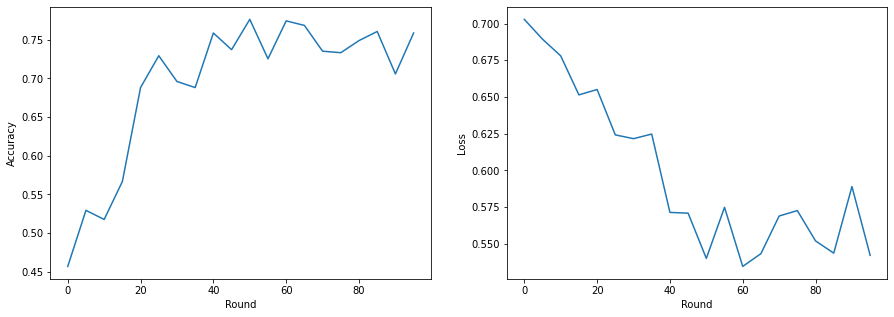

In [ ]:
import seaborn as sns

sampled_clients = np.random.choice(
  train_client_data.client_ids,
  size=CLIENTS_PER_ROUND,
  replace=False)
# build train data for selected clients



def make_plot(data_frame):
  plt.figure(figsize=(15, 5))
  plt.subplot(121)
  sns.lineplot(data=data_frame, x='Round', y='Accuracy' ,palette='dark')
  plt.subplot(122)
  sns.lineplot(data=data_frame, x='Round', y='Loss', palette='dark')

make_plot(data_frame)

evaluation = tff.learning.build_federated_evaluation(model_fn)
federated_train_data= get_federated_data(train_client_data, sampled_clients)
train_metrics = evaluation(state.model, federated_train_data)
print("train result")
print(str(train_metrics))
federated_test_data = get_federated_data(test_client_data, sampled_clients)
test_metrics = evaluation(state.model, federated_test_data)
print("test result")
print(str(test_metrics)) 